In [1]:
# importing all the libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import ImageGrid
import copy
import random
import pandas as pd
import math
import scipy
from scipy.stats import norm, expon
from scipy.linalg import null_space
import pandas as pd
import matplotlib as mpl

import os
cwd = os.getcwd()

%run ../functions_MCMC_alpha

In [2]:
burnin = 10000 #10k
n_after_burnin = 10000 #10k
delta_t = 0.3

sigma = 50.0
n_param = {'2-state':5, '3-state':9}

correlated = True
up_to_switches = 1
track = True

In [3]:
data_import = pd.read_csv(cwd+"/Rab11_2-state_track_8_ALPHA=0.3/Rab11_delta_y8.csv",
                          delimiter=',', index_col=0)
delta_y = np.array(data_import)

In [4]:
n_data = delta_y.shape[0]

In [5]:
list_of_folders = ['2-state', '3-state']

parameter_names = {'2-state':['v1', 'v2', 'loglambda1', 'loglambda2',
                            'sigma'],
                   '3-state':['v1', 'v2', 'log(lambda1)', 'log(lambda2)',
                              'log(lambda3)', 'p12', 'p21', 'p31', 'sigma'],}

parameter_names_tex = {'2-state':[r'$v_1$', r'$v_2$', r'log$(\lambda_1)$',
                                    r'log$(\lambda_2)$', 
                                    r'$\sigma$'],
                       '3-state':[r'$v_1$', r'$v_2$', r'log$(\lambda_1)$',
                                    r'log$(\lambda_2)$', r'log$(\lambda_3)$',
                                    r'$p_{12}$', r'$p_{21}$', r'$p_{31}$',
                                    r'$\sigma$']}

In [6]:
#importing the log_pi results of the inference
#this can take a while
#seed number is printed as they get imported
log_pi = {'2-state':None,
          '3-state':None}

for fold_name in list_of_folders:
    print("Importing logpi - folder", fold_name)
    log_pi[fold_name] = np.array(pd.read_csv("Rab11_"+fold_name+"_track_8_ALPHA=0.3/MCMC, seed 8, log_pi , burnin=10000, n_after_burnin=10000", index_col=0)).flatten()

Importing logpi - folder 2-state
Importing logpi - folder 3-state


In [7]:
AICs = {}

for fold_name in list_of_folders:
    AICs[fold_name] = [2*n_param[fold_name]-np.max(log_pi[fold_name])]

In [8]:
print(AICs) #choice is 3-state
print(AICs['3-state']<AICs['2-state'])

{'2-state': [1216.8829451168158], '3-state': [1209.3603696647956]}
True


In [9]:
BICs = {}

for fold_name in list_of_folders:
    BICs[fold_name] = [n_param[fold_name]*np.log(n_data)-np.max(log_pi[fold_name])]

In [10]:
print(BICs) #choice is 2-state
print(BICs['3-state']<BICs['2-state'])

{'2-state': [1233.2735184129683], '3-state': [1238.8634015978703]}
False


In [11]:
theta_all = {'2-state':[], '3-state':[]}
theta_best = {'2-state':[], '3-state':[]}

#importing the data - this does take a while
for fold_name in list_of_folders:
    print("Importing theta - folder", fold_name)
    for param in parameter_names[fold_name]:
        theta_all[fold_name] += [np.array(pd.read_csv("Rab11_"+fold_name+"_track_8_ALPHA=0.3/MCMC, seed 8, parameter "+param+", burnin=10000, n_after_burnin=10000", index_col=0)).flatten()]
    theta_all[fold_name] = np.array(theta_all[fold_name])
    theta_best[fold_name] = theta_all[fold_name][:, np.argmax(log_pi[fold_name])]

Importing theta - folder 2-state
Importing theta - folder 3-state


In [12]:
print('Noise reduction in %')
print((theta_best['2-state'][-1]-theta_best['3-state'][-1])
      /theta_best['2-state'][-1]*100)

Noise reduction in %
18.61366762353702


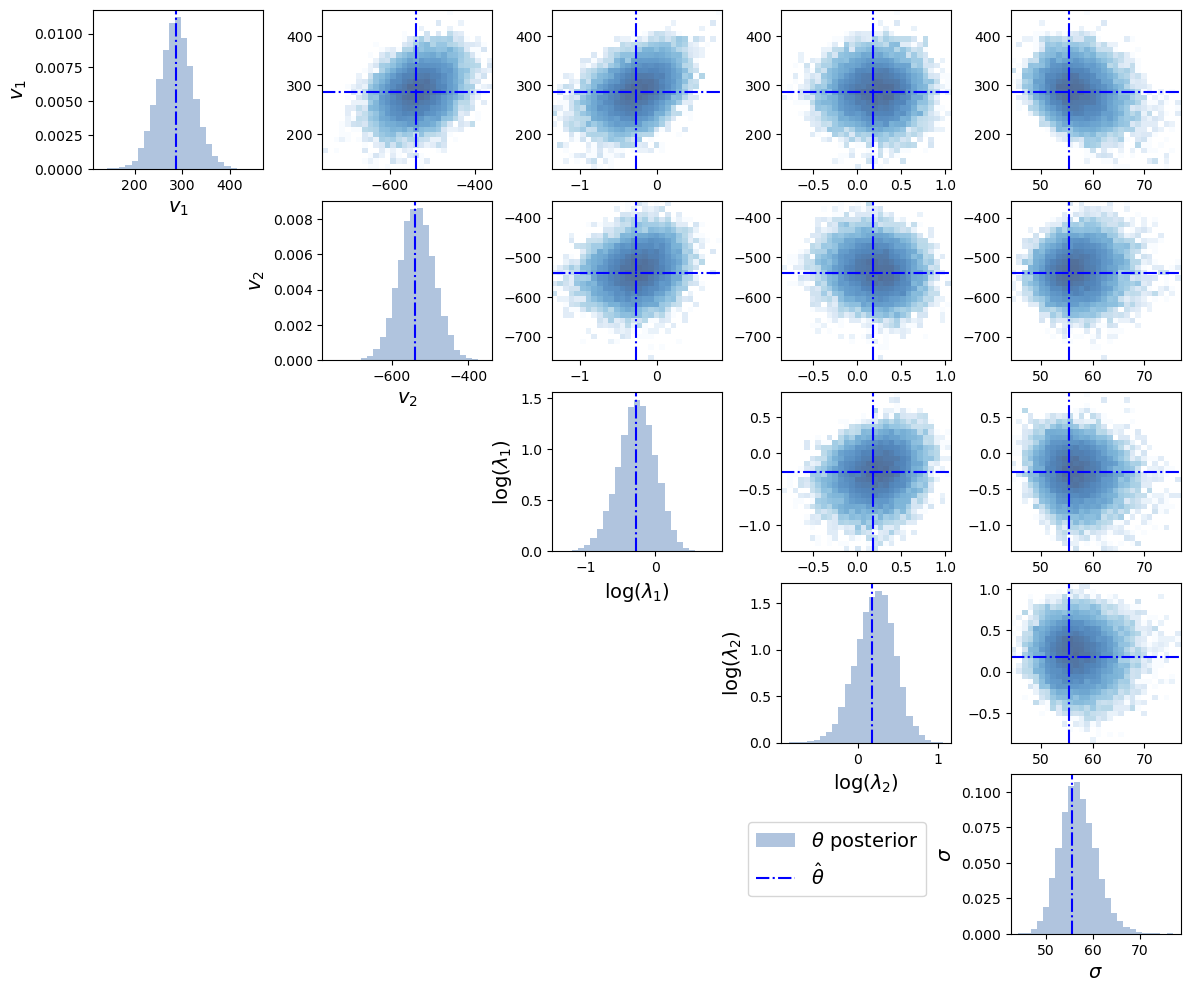

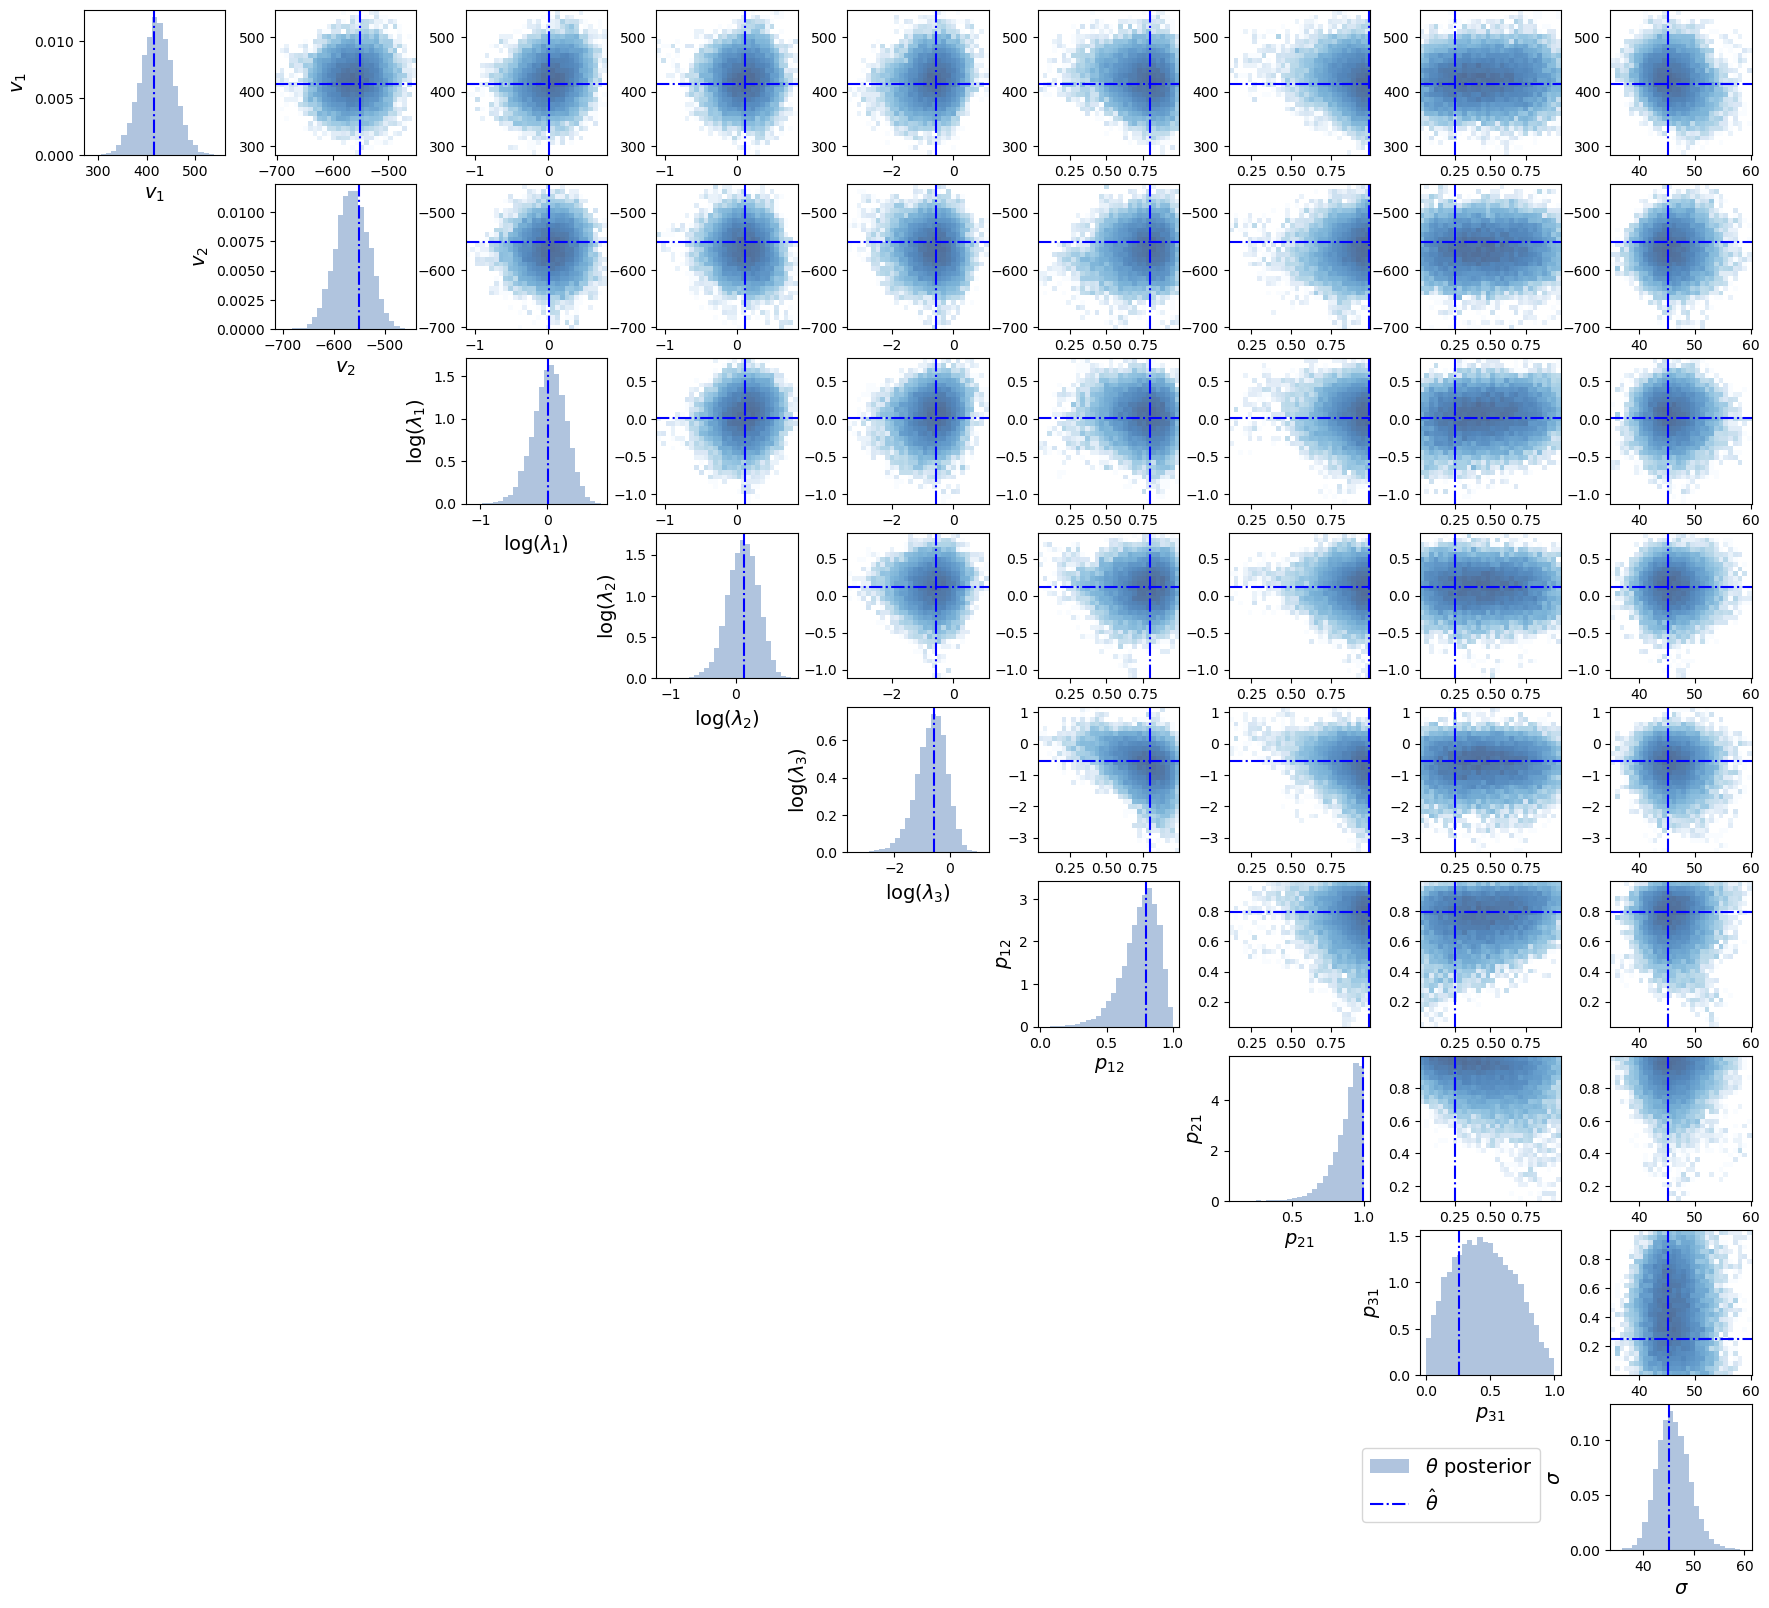

In [13]:
for fold_name in list_of_folders:
    
    theta = theta_all[fold_name]

    j1 = 0
    #plots
    fig, ax = plt.subplots(n_param[fold_name], n_param[fold_name],
                           figsize=(n_param[fold_name]*2+5,n_param[fold_name]*2+2))
    plt.subplots_adjust(wspace=0.35, hspace=0.2)
    for i in range(n_param[fold_name]):
        ax[i,i].set_ylabel(parameter_names_tex[fold_name][i], fontsize=14)
        ax[i,i].set_xlabel(parameter_names_tex[fold_name][i], fontsize=14)

    for i in range(n_param[fold_name]):
        ax[i,i].hist(theta[i,:], bins=25, density=True,
                     label=r'$\theta$ posterior', color='lightsteelblue')
        ax[i,i].axvline(theta_best[fold_name][i], linestyle='-.', color='blue',
                        label=r'$\hat\theta$')
    for i in range(n_param[fold_name]):
        for j in range(0,i):
            ax[i,j].axis('off')
        for j in range(i+1,n_param[fold_name]):
            #plt.title('Checking correlations')
            ax[i,j].hist2d(theta[j,:], theta[i,:], density=True, bins=30, alpha=0.7,
                           norm=colors.LogNorm(), cmap='Blues')
            ax[i,j].axhline(theta_best[fold_name][i], linestyle='-.', color='blue',
                            label=r'$\hat\theta$')
            ax[i,j].axvline(theta_best[fold_name][j], linestyle='-.', color='blue',
                            label=r'$\hat\theta$')
    plt.subplots_adjust(right=0.85)
    plt.legend(bbox_to_anchor=(-0.50, 0.7), fontsize=14, loc='upper right', borderaxespad=0)
    plt.savefig("track_B_"+fold_name+"_best_parameters_posteriors.png",
                format="png", dpi=600, bbox_inches="tight")
    plt.show()

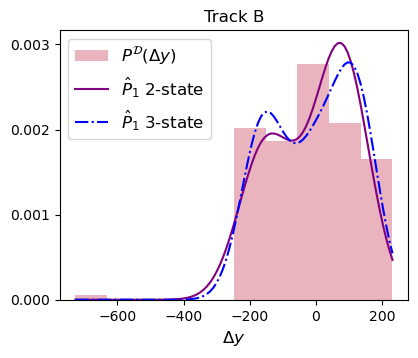

In [33]:
#plot data vs best fit
eval_points = np.linspace(np.min(delta_y), np.max(delta_y), 100)

nbins = 10

def get_parameters2(theta):
    V = np.zeros(2)
    V[0] = 1.0*theta[0]
    V[1] = 1.0*theta[1]
    Lambda = 1.0*np.exp(np.array(theta[2:4]))
    P = np.zeros((2,2))
    P[0,1] = 1.0
    P[1,0] = 1.0
    sigma = 1.0*theta[-1]
    
    return V, Lambda, P, sigma

fold_name = '2-state'
approx_pdf_comp2 = approx_pdf_theta(theta_best[fold_name], get_parameters2,
                                   delta_t, eval_points,
                                   up_to_switches = up_to_switches, track = False)

def get_parameters3(theta):
    """Obtaining parameters from theta"""
    V = np.array(list(theta[0:2])+[0.0])
    Lambda = np.exp(theta[2:5])
    P = np.array([[0.0, theta[-4], 1.0-theta[-4]],
                  [theta[-3], 0.0, 1.0-theta[-3]],
                  [theta[-2], 1-theta[-2], 0.0]])
    sigma = 1.0*theta[-1]
    #print(V, Lambda, P, sigma)
    return V, Lambda, P, sigma
    
fold_name = '3-state'
approx_pdf_comp3 = approx_pdf_theta(theta_best[fold_name], get_parameters3,
                                   delta_t, eval_points,
                                   up_to_switches = up_to_switches, track = False)

plt.figure(figsize=(4.5,3.5))
plt.title('Track B', fontsize=12)
plt.hist(delta_y, bins=nbins, density=True, color='#d46a7e', alpha=0.5,
         label=r'$P^\mathcal{D}(\Delta y)$')

plt.plot(eval_points, approx_pdf_comp2, '-', color='purple', label=str(r'$\hat P_1$ 2-state'))
plt.plot(eval_points, approx_pdf_comp3, '-.', color='blue', label=str(r'$\hat P_1$ 3-state'))
plt.legend(fontsize=12)
plt.yticks([0,0.001,0.002,0.003])
plt.xlabel(r'$\Delta y$', fontsize=12)
plt.savefig("compare_Rab11_track_8_best_fit_compared_to_data.png", format="png", dpi=1200, bbox_inches="tight")

In [15]:
theta_best

{'2-state': array([ 2.86468196e+02, -5.39195238e+02, -2.68762119e-01,  1.80340768e-01,
         5.54686202e+01]),
 '3-state': array([ 4.14735452e+02, -5.50744825e+02,  1.80075024e-02,  1.21020671e-01,
        -5.57198514e-01,  7.96994367e-01,  9.95811748e-01,  2.53704554e-01,
         4.51438756e+01])}

In [16]:
minmax = np.linspace(np.min(delta_y), np.max(delta_y), 400)
X, Y = np.meshgrid(minmax, minmax)

V_best, Lambda_best, P_best, sigma_best = get_parameters2(theta_best['2-state'])

#computing the approximate PDF P1(Delta y_1, Delta y_2)
approx_pdf_track_res_best2 = np.array([[np.prod(approx_pdf_track_up_to_1_switch(V_best,
                                                                                 Lambda_best,
                                                                          P_best, sigma_best,
                                                                          delta_t, 
                                                           np.array([X[i,j], Y[i,j]])))
                                  for i in range(X.shape[0])]
                                 for j in range(X.shape[0])])

V_best, Lambda_best, P_best, sigma_best = get_parameters3(theta_best['3-state'])

#computing the approximate PDF P1(Delta y_1, Delta y_2)
approx_pdf_track_res_best3 = np.array([[np.prod(approx_pdf_track_up_to_1_switch(V_best,
                                                                                 Lambda_best,
                                                                          P_best, sigma_best,
                                                                          delta_t, 
                                                           np.array([X[i,j], Y[i,j]])))
                                  for i in range(X.shape[0])]
                                 for j in range(X.shape[0])])

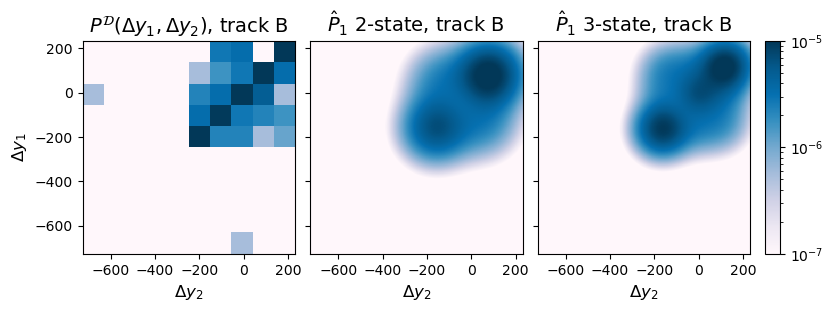

In [34]:
fig = plt.figure(figsize=(9,3))
ax = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15)
ax[0].hist2d(delta_y.flatten()[1:], delta_y.flatten()[0:-1], density=True, bins=10,
             norm=colors.LogNorm(vmin=10**(-7), vmax=10**(-5)), cmap='PuBu')

ax[0].set_title(r'$P^\mathcal{D}(\Delta y_1, \Delta y_2)$, track B', fontsize=14)
ax[0].set_xlabel(r'$\Delta y_2$', fontsize=12)
ax[0].set_ylabel(r'$\Delta y_1$', fontsize=12)

cmap = mpl.colormaps['PuBu']
# Take colors at regular intervals spanning the colormap.
colors_vec = cmap(np.linspace(0, 1, 400))
ax[0].set_facecolor(colors_vec[0])

pcm = ax[1].pcolor(X, Y, approx_pdf_track_res_best2.T,
                   norm=colors.LogNorm(vmin=10**(-7), vmax=10**(-5)), cmap='PuBu')
ax[1].set_title(r'$\hat P_1$ 2-state, track B', fontsize=14)
ax[1].set_xlabel(r'$\Delta y_2$', fontsize=12)

pcm = ax[2].pcolor(X, Y, approx_pdf_track_res_best3.T,
                   norm=colors.LogNorm(vmin=10**(-7), vmax=10**(-5)), cmap='PuBu')
ax[2].set_title(r'$\hat P_1$ 3-state, track B', fontsize=14)
ax[2].set_xlabel(r'$\Delta y_2$', fontsize=12)


ax[2].cax.colorbar(pcm)
ax[2].cax.toggle_label(True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig("compare_Rab11_track_8_P_Deltay_1,Deltay_2_best.png",
            format="png", bbox_inches="tight", dpi=1200)

In [18]:
delta_y.shape

(196, 1)

In [19]:
196*0.3

58.8

In [20]:
theta_best

{'2-state': array([ 2.86468196e+02, -5.39195238e+02, -2.68762119e-01,  1.80340768e-01,
         5.54686202e+01]),
 '3-state': array([ 4.14735452e+02, -5.50744825e+02,  1.80075024e-02,  1.21020671e-01,
        -5.57198514e-01,  7.96994367e-01,  9.95811748e-01,  2.53704554e-01,
         4.51438756e+01])}

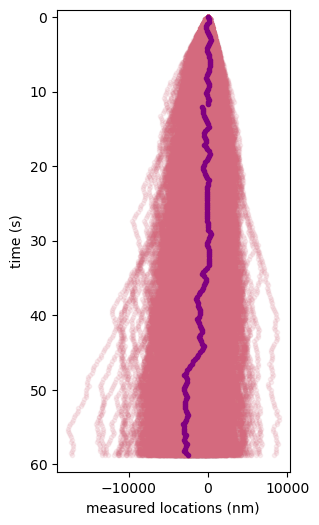

In [21]:
plt.figure(figsize=(3,6))
N = n_data
rebuild_y_array = [None for _ in range(1000)]
for it in range(1000):
    
    delta_Y = get_data_dy(delta_t = delta_t, T = 58.8, theta = theta_best['2-state'],
                          get_parameters = get_parameters2, 
                          seed = 1223+5999*it, correlated = correlated)
    rebuild_y_array[it] = np.zeros(N+1)
    for i in range(1, N+1):
        rebuild_y_array[it][i] += rebuild_y_array[it][i-1] + delta_Y[i-1]
    plt.plot(rebuild_y_array[it],delta_t*np.arange(0,N+1), '.', color='#d46a7e', alpha=0.1)

rebuild_y = np.zeros(N+1)
for i in range(1, N+1):
    rebuild_y[i] += rebuild_y[i-1] + delta_y[i-1]
plt.plot(rebuild_y,delta_t*np.arange(0,N+1), '.', color='purple', alpha=1)

plt.ylim([-1,61])
plt.xlabel(r'measured locations (nm)', fontsize=10)
plt.ylabel(r'time (s)', fontsize=10)
plt.gca().invert_yaxis()
#plt.legend()
plt.savefig('y_plot_all_tracks_Rab11_8_2-state.png', format="png", dpi=1200, bbox_inches="tight")
plt.show()

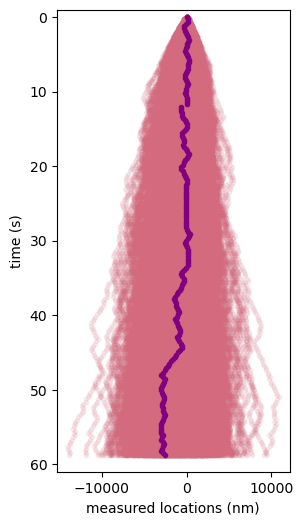

In [22]:
plt.figure(figsize=(3,6))
N = n_data
rebuild_y_array = [None for _ in range(1000)]
for it in range(1000):
    
    delta_Y = get_data_dy(delta_t = delta_t, T = 58.8, theta = theta_best['3-state'],
                          get_parameters = get_parameters3, 
                          seed = 1223+5999*it, correlated = correlated)
    rebuild_y_array[it] = np.zeros(N+1)
    for i in range(1, N+1):
        rebuild_y_array[it][i] += rebuild_y_array[it][i-1] + delta_Y[i-1]
    plt.plot(rebuild_y_array[it],delta_t*np.arange(0,N+1), '.', color='#d46a7e', alpha=0.1)

rebuild_y = np.zeros(N+1)
for i in range(1, N+1):
    rebuild_y[i] += rebuild_y[i-1] + delta_y[i-1]
plt.plot(rebuild_y,delta_t*np.arange(0,N+1), '.', color='purple', alpha=1)

plt.ylim([-1,61])
plt.xlabel(r'measured locations (nm)', fontsize=10)
plt.ylabel(r'time (s)', fontsize=10)
plt.gca().invert_yaxis()
#plt.legend()
plt.savefig('y_plot_all_tracks_Rab11_8_3-state.png', format="png", dpi=1200, bbox_inches="tight")
plt.show()

In [23]:
V, Lambda, P, sigma = get_parameters2(theta_best['2-state'])

#Building Q transpose
Q = np.zeros((2,2))
for i in range(2):
    for j in range(0,i):
        Q[i,j] = Lambda[i]*P[i,j]
    Q[i,i] = -Lambda[i]
    for j in range(i+1,2):
        Q[i,j] = Lambda[i]*P[i,j]
Qt = Q.T

#Computing w s.t. Q^T w = 0 and then P(st)
W = null_space(Q.T)
P_st = (W / np.sum(W)).flatten()

print("Average velocity for the calibrated 2-state model", np.sum(np.multiply(P_st,V)))

Average velocity for the calibrated 2-state model -35.18887976451441


In [24]:
V, Lambda, P, sigma = get_parameters3(theta_best['3-state'])

#Building Q transpose
Q = np.zeros((3,3))
for i in range(3):
    for j in range(0,i):
        Q[i,j] = Lambda[i]*P[i,j]
    Q[i,i] = -Lambda[i]
    for j in range(i+1,3):
        Q[i,j] = Lambda[i]*P[i,j]
Qt = Q.T

#Computing w s.t. Q^T w = 0 and then P(st)
W = null_space(Q.T)
P_st = (W / np.sum(W)).flatten()

print("Average velocity for the calibrated 3-state model", np.sum(np.multiply(P_st,V)))

Average velocity for the calibrated 3-state model -26.047537544815953


In [25]:
T = 58.8
print("Average velocity of the data", rebuild_y[-1]/T)

Average velocity of the data -42.73809523809524


In [26]:
save_all_velocities = {'2-state':np.zeros(40000), '3-state':np.zeros(40000)}

for it in range(40000):
    
    V, Lambda, P, sigma = get_parameters2(theta_all['2-state'][:,it])

    #Building Q transpose
    Q = np.zeros((2,2))
    for i in range(2):
        for j in range(0,i):
            Q[i,j] = Lambda[i]*P[i,j]
        Q[i,i] = -Lambda[i]
        for j in range(i+1,2):
            Q[i,j] = Lambda[i]*P[i,j]
    Qt = Q.T

    #Computing w s.t. Q^T w = 0 and then P(st)
    W = null_space(Q.T)
    P_st = (W / np.sum(W)).flatten()

    save_all_velocities['2-state'][it] = np.sum(np.multiply(P_st,V))
    
    
    model_type = '3-state'
    V, Lambda, P, sigma = get_parameters3(theta_all['3-state'][:,it])

    #Building Q transpose
    Q = np.zeros((3,3))
    for i in range(3):
        for j in range(0,i):
            Q[i,j] = Lambda[i]*P[i,j]
        Q[i,i] = -Lambda[i]
        for j in range(i+1,3):
            Q[i,j] = Lambda[i]*P[i,j]
    Qt = Q.T

    #Computing w s.t. Q^T w = 0 and then P(st)
    W = null_space(Q.T)
    P_st = (W / np.sum(W)).flatten()
    save_all_velocities['3-state'][it] = np.sum(np.multiply(P_st,V))

-29.522466050466132
58.391438706851076


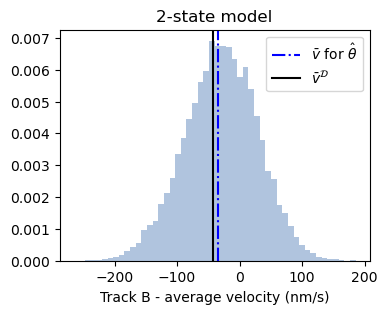

-30.846575921549817
57.973964693666694


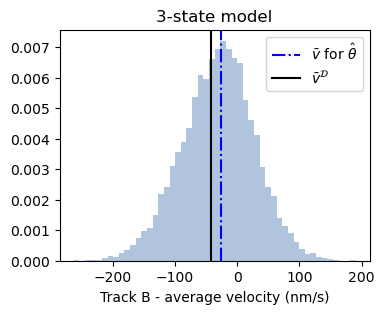

In [27]:
for model_type in list_of_folders:
    print(np.mean(save_all_velocities[model_type]))
    print(np.std(save_all_velocities[model_type]))
    plt.figure(figsize=(4,3))
    plt.title(model_type+" model")
    plt.hist(save_all_velocities[model_type], bins=50, color='lightsteelblue',
             density=True)
    plt.axvline(save_all_velocities[model_type][np.argmax(log_pi[model_type])],
                linestyle='-.', color='blue',
                label=r'$\bar{v}$ for $\hat\theta$')
    plt.axvline(rebuild_y[-1]/T,
                linestyle='-', color='black',
                label=r'$\bar{v}^{\mathcal{D}}$')
    plt.legend()
    plt.xlabel('Track B average velocity (nm/s)')
    plt.show()